## 📋 Project Requirements Checklist

✅ **4.1 Task Selection**: Classification task justified by categorical labels  
✅ **4.2 Data Preparation**: Train/test split with preprocessing  
✅ **4.3 Architecture & Training**: ResNet50 with training diagnosis  
✅ **4.4 Model Evaluation**: Comprehensive metrics on test set  

**Dataset**: Alzheimer's 4-class MRI  
**Task**: Multi-class Image Classification  
**Model**: ResNet50 (Transfer Learning)

In [20]:
# 1. SETUP
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device
# Device configuration - Apple Silicon M3 GPU support
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"✓ Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✓ Using NVIDIA GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("⚠ Using CPU (slower training)")


# Paths
PROJECT_ROOT = Path("../..")  # Go up to FinalProject root from scripts/Part_4/
DATA_DIR = PROJECT_ROOT / "Data" / "Alzheimer_MRI"
RESULTS_DIR = PROJECT_ROOT / "Results" / "MRI_Classification"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print(f"✓ Results: {RESULTS_DIR}")

✓ Using Apple Silicon GPU (MPS)
✓ Results: ../../Results/MRI_Classification


In [21]:
# GPU Verification - Run this to confirm GPU is being used
print("="*70)
print("GPU/DEVICE CONFIGURATION")
print("="*70)
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print(f"Device type: {device.type}")

if device.type == 'mps':
    print("\n🚀 Apple Silicon M3 GPU is ACTIVE!")
    print("   Training will use Metal Performance Shaders (MPS)")
    print("   Expected speedup: 3-5x faster than CPU")
elif device.type == 'cuda':
    print(f"\n🚀 NVIDIA GPU is ACTIVE: {torch.cuda.get_device_name(0)}")
else:
    print("\n⚠️  Running on CPU - training will be slower")
    print("   Consider checking your PyTorch installation for MPS support")

# Quick GPU test
try:
    test_tensor = torch.randn(100, 100).to(device)
    result = test_tensor @ test_tensor.T
    print(f"\n✓ GPU test passed! Tensor computation successful.")
except Exception as e:
    print(f"\n✗ GPU test failed: {e}")
print("="*70)

GPU/DEVICE CONFIGURATION
PyTorch version: 2.9.1
Device: mps
Device type: mps

🚀 Apple Silicon M3 GPU is ACTIVE!
   Training will use Metal Performance Shaders (MPS)
   Expected speedup: 3-5x faster than CPU

✓ GPU test passed! Tensor computation successful.


## **Requirement 4.1: Task Selection**

Download from: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images

Expected structure:
```
Data/Alzheimer_MRI/
├── train/
│   ├── MildDemented/
│   ├── ModerateDemented/
│   ├── NonDemented/
│   └── VeryMildDemented/
└── test/
    └── [same structure]
```

In [22]:
# Verify dataset
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]
class_paths = [DATA_DIR / cls for cls in classes]

print(f"📁 Checking DATA_DIR: {DATA_DIR.absolute()}\n")

all_exist = True
for cls, cls_path in zip(classes, class_paths):
    exists = cls_path.exists()
    status = "✓" if exists else "✗"
    if exists:
        jpg_count = len(list(cls_path.glob('*.jpg')))
        print(f"  {status} {cls:<30} ({jpg_count:>6} images)")
    else:
        print(f"  {status} {cls:<30} (NOT FOUND)")
        all_exist = False

print()

if all_exist:
    print("="*70)
    print("TASK SELECTION ANALYSIS")
    print("="*70)
    print(f"Dataset Type: Labeled image folders")
    print(f"Classes: {classes}")
    print(f"Number: {len(classes)}")
    
    # Count images per class
    print("\n📊 Dataset Statistics:")
    total_images = 0
    for cls, cls_path in zip(classes, class_paths):
        jpg_files = list(cls_path.glob('*.jpg'))
        count = len(jpg_files)
        total_images += count
        print(f"  {cls:<25}: {count:>6} images")
    
    print(f"\n  {'TOTAL':<25}: {total_images:>6} images")
    print(f"\n🎯 TASK: Multi-class Classification")
    print(f"Rationale: Categorical labels → Classification task")
    print("="*70)
else:
    print("="*70)
    print("❌ DATASET NOT FOUND")
    print("="*70)
    print("Expected folders in:", DATA_DIR.absolute())
    print("\nPlease check:")
    print("  1. DATA_DIR path is correct")
    print("  2. Class folders exist with correct names")
    print("  3. Folders contain .jpg files")
    print("="*70)

📁 Checking DATA_DIR: /Users/ldr0/Documents/UPM/Complex Data/FinalProject/scripts/Part_4/../../Data/Alzheimer_MRI

  ✓ Mild Dementia                  (  5002 images)
  ✓ Moderate Dementia              (   488 images)


  ✓ Non Demented                   ( 67222 images)
  ✓ Very mild Dementia             ( 13725 images)

TASK SELECTION ANALYSIS
Dataset Type: Labeled image folders
Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
Number: 4

📊 Dataset Statistics:
  Mild Dementia            :   5002 images
  Moderate Dementia        :    488 images
  Non Demented             :  67222 images
  Very mild Dementia       :  13725 images

  TOTAL                    :  86437 images

🎯 TASK: Multi-class Classification
Rationale: Categorical labels → Classification task


## **Requirement 4.2: Data Preparation**

Loading images from class folders...
  Class: Mild Dementia             Files Found:   5002
  Class: Moderate Dementia         Files Found:    488
  Class: Non Demented              Files Found:  67222
  Class: Very mild Dementia        Files Found:  13725

✓ Total images loaded: 86437

Total images: 86437
Train: 73471 (85.0%)
Test: 12966 (15.0%)

📈 DATASET STATISTICS
Class                     Train      Test       Total     
----------------------------------------------------------------------
Mild Dementia             4252       750        5002      
Moderate Dementia         415        73         488       
Non Demented              57138      10084      67222     
Very mild Dementia        11666      2059       13725     


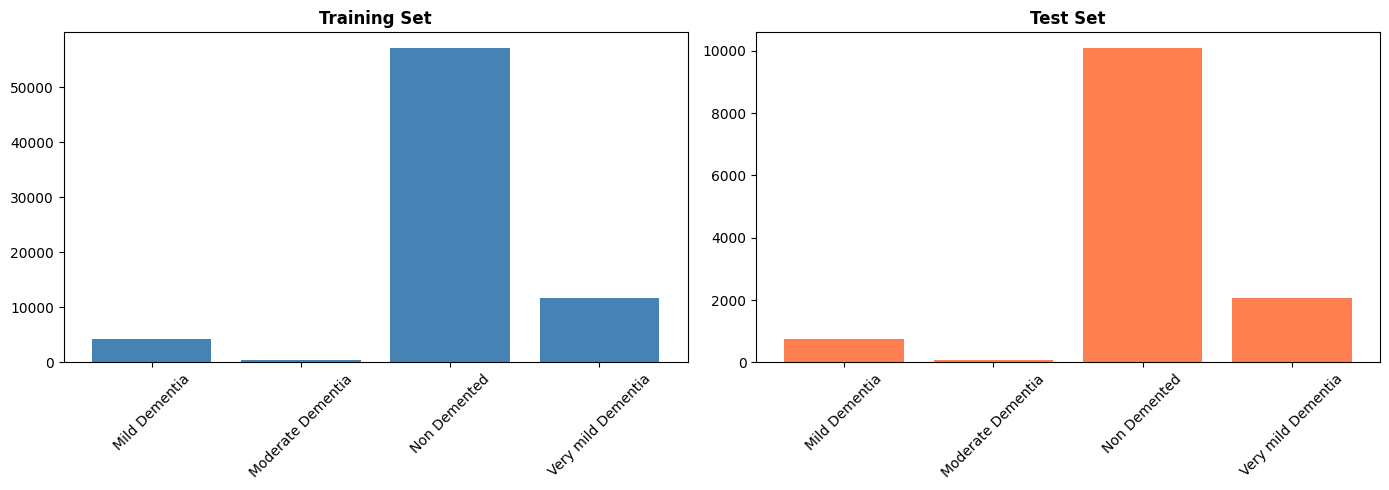

In [23]:
# Load dataset and create train/test split
# Load all images and labels from class folders
image_paths = []
labels = []

print("Loading images from class folders...")
for class_label, class_name in enumerate(classes):
    class_dir = DATA_DIR / class_name
    if not class_dir.exists():
        print(f"⚠ Warning: Folder {class_dir} does not exist. Skipping.")
        continue
    
    files = list(class_dir.glob('*.jpg'))
    print(f"  Class: {class_name:<25} Files Found: {len(files):>6}")
    
    for file_path in files:
        image_paths.append(str(file_path))
        labels.append(class_label)

if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

print(f"\n✓ Total images loaded: {len(image_paths)}")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.15, shuffle=True, random_state=42, stratify=labels
)

print(f"\nTotal images: {len(image_paths)}")
print(f"Train: {len(x_train)} ({100*len(x_train)/len(image_paths):.1f}%)")
print(f"Test: {len(x_test)} ({100*len(x_test)/len(image_paths):.1f}%)")

# Dataset statistics
def count_class_distribution(label_list, classes):
    stats = {}
    for i, cls in enumerate(classes):
        count = label_list.count(i)
        stats[cls] = count
    return stats

train_stats = count_class_distribution(y_train, classes)
test_stats = count_class_distribution(y_test, classes)

print("\n📈 DATASET STATISTICS")
print("="*70)
print(f"{'Class':<25} {'Train':<10} {'Test':<10} {'Total':<10}")
print("-"*70)
for cls in sorted(train_stats.keys()):
    tr, te = train_stats[cls], test_stats[cls]
    print(f"{cls:<25} {tr:<10} {te:<10} {tr+te:<10}")
print("="*70)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.bar(train_stats.keys(), train_stats.values(), color='steelblue')
ax1.set_title('Training Set', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax2.bar(test_stats.keys(), test_stats.values(), color='coral')
ax2.set_title('Test Set', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig(RESULTS_DIR / '01_distribution.png', dpi=300)
plt.show()

In [24]:
# Preprocessing with noise reduction
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(3, sigma=(0.1, 2.0)),  # Noise reduction
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

print("✓ Preprocessing defined:")
print("  • Noise reduction: Gaussian blur")
print("  • Augmentation: Flip, rotate, color jitter")
print("  • Normalization: ImageNet statistics")

# Custom Dataset class for our data structure
from torch.utils.data import Dataset

class AlzheimerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = datasets.folder.default_loader(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

✓ Preprocessing defined:
  • Noise reduction: Gaussian blur
  • Augmentation: Flip, rotate, color jitter
  • Normalization: ImageNet statistics


In [25]:
# Create datasets
# Split train into train + validation (80-20 of training data)
train_val_paths, val_paths, train_val_labels, val_labels = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=True, random_state=42, stratify=y_train
)

train_dataset = AlzheimerDataset(train_val_paths, train_val_labels, transform=data_transforms['train'])
val_dataset = AlzheimerDataset(val_paths, val_labels, transform=data_transforms['test'])
test_dataset = AlzheimerDataset(x_test, y_test, transform=data_transforms['test'])

class_names = classes
print(f"\n✓ Splits: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
print(f"✓ Classes: {class_names}")

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


✓ Splits: Train=58776, Val=14695, Test=12966
✓ Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


## **Requirement 4.3: Architecture Selection & Training**

In [26]:
# Model definition
class AlzheimerClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.resnet = models.resnet50(pretrained=True)
        
        # Freeze backbone
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Custom classifier
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

model = AlzheimerClassifier(len(class_names)).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n" + "="*70)
print("MODEL ARCHITECTURE")
print("="*70)
print(f"Base: ResNet50 (ImageNet pretrained)")
print(f"Total params: {total_params:,}")
print(f"Trainable: {trainable:,}")
print(f"Frozen: {total_params-trainable:,}")
print("="*70)


MODEL ARCHITECTURE
Base: ResNet50 (ImageNet pretrained)
Total params: 24,691,012
Trainable: 1,182,980
Frozen: 23,508,032


In [27]:
# Training configuration
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)

num_epochs = 25
early_stop_patience = 7
best_val_acc = 0.0
patience_counter = 0

print("✓ Configuration:")
print(f"  • Epochs: {num_epochs}")
print(f"  • Optimizer: Adam (lr=0.001, wd=1e-4)")
print(f"  • Scheduler: ReduceLROnPlateau")
print(f"  • Early stopping: {early_stop_patience} epochs")

✓ Configuration:
  • Epochs: 25
  • Optimizer: Adam (lr=0.001, wd=1e-4)
  • Scheduler: ReduceLROnPlateau
  • Early stopping: 7 epochs


In [28]:
# Training functions
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc='Train', leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
    
    return running_loss / total, 100. * correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Val', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return running_loss / total, 100. * correct / total, all_preds, all_labels

print("✓ Training functions defined")

✓ Training functions defined


In [29]:
# Training loop
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

print("\n" + "="*70)
print("TRAINING")
print("="*70)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-"*70)
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion)
    
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"LR: {current_lr:.2e}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), RESULTS_DIR / 'best_model.pth')
        print(f"✓ Best model saved! (Val Acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= early_stop_patience:
        print(f"\n⚠ Early stopping at epoch {epoch+1}")
        break

print(f"\n{'='*70}")
print(f"Best Val Acc: {best_val_acc:.2f}%")
print("="*70)


TRAINING

Epoch 1/25
----------------------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
# Training diagnostics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history['train_loss'], 'o-', label='Train')
axes[0, 0].plot(history['val_loss'], 's-', label='Val')
axes[0, 0].set_title('Loss', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(history['train_acc'], 'o-', label='Train')
axes[0, 1].plot(history['val_acc'], 's-', label='Val')
axes[0, 1].set_title('Accuracy', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(history['lr'], 'o-', color='red')
axes[1, 0].set_title('Learning Rate', fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(alpha=0.3)

diff = np.array(history['train_acc']) - np.array(history['val_acc'])
axes[1, 1].plot(diff, 'o-', color='purple')
axes[1, 1].axhline(0, color='k', linestyle='--')
axes[1, 1].axhline(5, color='r', linestyle='--', label='5% threshold')
axes[1, 1].set_title('Overfitting Analysis (Train-Val)', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Training Diagnostics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / '02_training.png', dpi=300)
plt.show()

# Diagnosis
print("\n" + "="*70)
print("TRAINING DIAGNOSIS")
print("="*70)
final_gap = history['train_acc'][-1] - history['val_acc'][-1]
if final_gap > 10:
    print("⚠ Overfitting detected (gap > 10%)")
elif final_gap > 5:
    print("⚠ Mild overfitting (gap 5-10%)")
else:
    print("✓ Well-generalized (gap < 5%)")
print("="*70)

## **Requirement 4.4: Model Evaluation**

In [ ]:
# Load best model and evaluate
model.load_state_dict(torch.load(RESULTS_DIR / 'best_model.pth'))
test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion)

print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print("="*70)

In [ ]:
# Classification report
print("\nCLASSIFICATION REPORT")
print("="*70)
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))

In [ ]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(RESULTS_DIR / '03_confusion_matrix.png', dpi=300)
plt.show()

print("\nPer-Class Accuracy:")
for i, name in enumerate(class_names):
    acc = 100 * cm[i, i] / cm[i].sum()
    print(f"  {name:<25}: {acc:.2f}%")

In [ ]:
# ROC curves
model.eval()
all_probs, all_true = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, 1)
        all_probs.append(probs.cpu().numpy())
        all_true.append(labels.numpy())

all_probs = np.vstack(all_probs)
all_true = np.concatenate(all_true)

y_bin = label_binarize(all_true, classes=range(len(class_names)))

plt.figure(figsize=(10, 8))
auc_scores = []

for i, name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC={roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curves', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / '04_roc.png', dpi=300)
plt.show()

print(f"\nMean AUC: {np.mean(auc_scores):.4f}")

## Final Summary

In [ ]:
summary = {
    'Task': 'Multi-class Classification',
    'Classes': len(class_names),
    'Architecture': 'ResNet50 (Transfer Learning)',
    'Test Accuracy': f'{test_acc:.2f}%',
    'Mean AUC': f'{np.mean(auc_scores):.4f}',
}

print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
for k, v in summary.items():
    print(f"{k:<20}: {v}")
print("="*70)

print("\n✅ PROJECT REQUIREMENTS COMPLETED:")
print("  4.1 Task Selection ✓")
print("  4.2 Data Preparation ✓")
print("  4.3 Architecture & Training ✓")
print("  4.4 Model Evaluation ✓")

print(f"\n📁 Results saved to: {RESULTS_DIR}")